# Atypical & Ext & Misclassified Hendricks

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv, find_dotenv
import numpy as np
import datetime, os
import tarfile
import os
import json
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import torch
from train_multiview_network import TrainMultiInputModel
from multi_view_classification_network import MultiInputModel
from data_loader import MultiInputLoader
from config import get_config, get_aty_data_config, get_ext_data_config
import seaborn as sns
import copy

### Saved Model (MultiView)

In [3]:
torch.cuda.empty_cache()
model_config, data_config = get_config()
trainer = TrainMultiInputModel(model_config,data_config)
model_recto = model_config['model_recto']
model_verso =   model_config['model_verso']            
model = MultiInputModel(model_recto,model_verso,pretrained=True, fine_tune=model_config['fine_tune'], num_classes=7)
model_name = 'model_recto_ResNet50_model_verso_ResNet50_epochs_30_lr_0.001_batch_size_32_pretrained_True_fine_tune_False'
checkpoint = torch.load(f'{trainer.main_path}/outputs/'+model_name+'.pth', map_location="cuda")
print('Loading trained model weights...')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(trainer.device)
trainer.model = copy.deepcopy(model)

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
Loading trained model weights...


### Saved results

In [10]:
with open("outputs/test_results_full_evalmode.json") as f:
    all_outputs = json.load(f)

### Get Aty & Ext Data

In [4]:
data_aty_config = get_aty_data_config()
data_ext_config = get_ext_data_config()

In [5]:
aty_loader = MultiInputLoader(data_aty_config)

atyRecto_loader,atyVerso_loader = aty_loader.get_data_loaders()

In [6]:
ext_loader = MultiInputLoader(data_ext_config)

extRecto_loader, extVerso_loader = ext_loader.get_data_loaders()

### Hendricks Study

In [27]:
y_predT = all_outputs[model.name]['pred']
scoreTyp = all_outputs[model.name]['max_probs']

In [29]:
real_labels = [label.tolist() for _,label in trainer.testRectoloader]
real_labels = [item for sublist in real_labels for item in sublist]

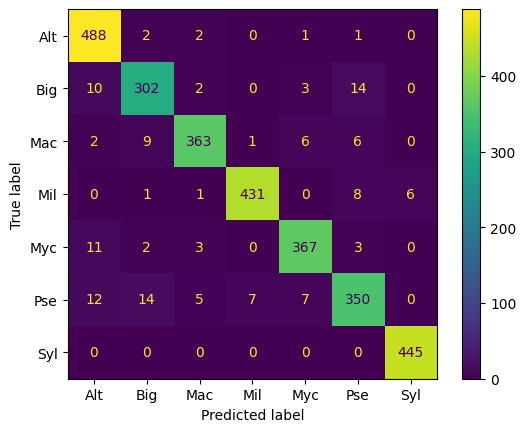

Accuracy : 0.9518197573656846
Balanced Accuracy : 0.9484692031541793


In [30]:
y_pred=y_predT
y_obs=real_labels
# let's use sklearn
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
#y_pred=le.inverse_transform(y_pred)
y_obs=le.inverse_transform(y_obs)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_obs,
y_pred,labels=lb),display_labels=lb)
disp.plot()
plt.show()
print("Accuracy : "+str(accuracy_score(y_obs, y_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(y_obs, y_pred)))

In [7]:
y_predA,scoreAty,_ = trainer.predict(atyRecto_loader,atyVerso_loader)

  0%|          | 0/21 [00:00<?, ?it/s]

In [8]:
y_predE,scoreExt,_ = trainer.predict(extRecto_loader,extVerso_loader)

  0%|          | 0/13 [00:00<?, ?it/s]

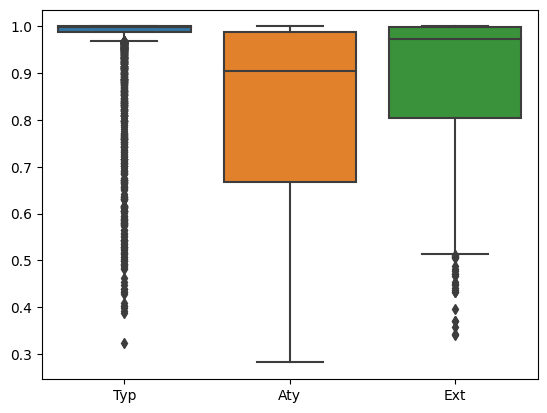

In [12]:
score=np.concatenate((scoreTyp,scoreAty,scoreExt))
qui=np.concatenate((np.repeat("Typ",len(scoreTyp)),
np.repeat("Aty",len(scoreAty)),
np.repeat("Ext",len(scoreExt))))
d = {'qui': qui, 'score': score}
df = pd.DataFrame(data=d)
ax = sns.boxplot(data=df,x=qui,y=score)
# plt.legend(labels=['Typ', 'Aty','Ext'])
plt.show()

In [36]:
print(np.mean(scoreTyp)) ; print(np.mean(scoreAty)) ;
print(np.mean(scoreExt))

0.9630038420393727
0.821173058819881
0.8736748673437815


In [14]:
from scipy.stats import ttest_ind

print(ttest_ind(scoreTyp,scoreAty,alternative = 'greater'))
print(ttest_ind(scoreTyp,scoreExt,alternative = 'greater'))
print(ttest_ind(scoreAty,scoreExt,alternative = 'greater'))

Ttest_indResult(statistic=27.00235558408596, pvalue=1.8789604935236204e-146)
Ttest_indResult(statistic=15.185298195047537, pvalue=1.1037846787666052e-50)
Ttest_indResult(statistic=-4.379495911704578, pvalue=0.9999934514641846)


In [15]:
lb=["Alt","Big","Mac","Mil","Myc","Pse","Syl"]
le = preprocessing.LabelEncoder()
le.fit(lb)
y_predA_label=le.inverse_transform(y_predA)
y_predE_label=le.inverse_transform(y_predE)
y_predT_label=y_predT

In [16]:
d={'PredAty':y_predA_label}; df=pd.DataFrame(data=d) ; df['PredAty'].value_counts()

Alt    193
Mac    164
Pse     94
Myc     86
Big     66
Syl     29
Mil     17
Name: PredAty, dtype: int64

In [17]:
d={'PredExt':y_predE_label}; df=pd.DataFrame(data=d) ; df['PredExt'].value_counts()

Syl    283
Mac     63
Alt     29
Mil      9
Myc      6
Pse      3
Big      1
Name: PredExt, dtype: int64

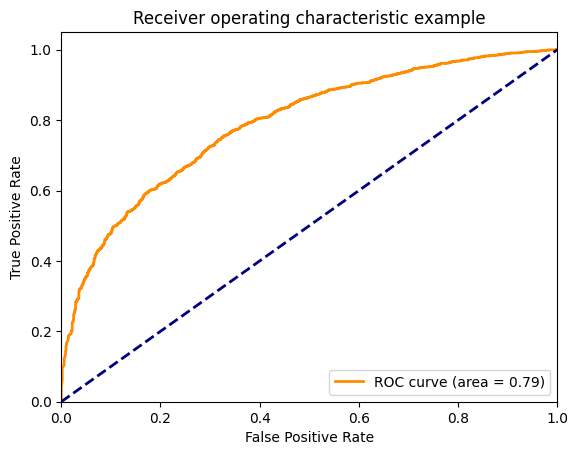

In [18]:
from sklearn.metrics import roc_curve, auc
qui=np.concatenate((np.zeros(len(scoreTyp)),
np.zeros(len(scoreAty))+1,
np.zeros(len(scoreExt))+1))
score=np.concatenate((scoreTyp,scoreAty,scoreExt))
fpr, tpr, thresholds = roc_curve(qui,score,pos_label=0)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
fpr,
tpr,
color="darkorange",
lw=lw,
label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [19]:
# computing younden's index (True Skill Statistic)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
print((thresholds[idx],tpr[idx],fpr[idx]))

import copy
out=copy.deepcopy(score)
out[score<seuil]=0
out[score>=seuil]=1

# precision
print((sum(out != qui) / out.shape)[0])

(0.9884800910949707, 0.7438474870017331, 0.31639501438159157)
0.7278513238289206


## Atypical Study

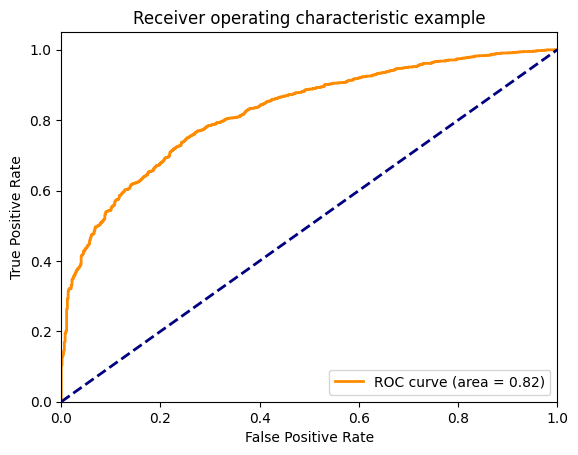

In [20]:
# courbe de ROC
from sklearn.metrics import roc_curve, auc
qui=np.concatenate((np.zeros(len(scoreTyp)),
                    np.zeros(len(scoreAty))+1))
score=np.concatenate((scoreTyp,scoreAty))
fpr, tpr, thresholds = roc_curve(qui,score,pos_label=0)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
fpr,
tpr,
color="darkorange",
lw=lw,
label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#### Maybe analysis

In [21]:
atydatasetRecto, _ = aty_loader.get_datasets()
PATH_ATY_DATASET_RECTO = [os.path.basename(path) for path in atydatasetRecto.all_imgs]

In [22]:
may_pred = [pred for (pred,true) in zip(y_predA_label,PATH_ATY_DATASET_RECTO) if any(item in true for item in lb) ]
may_true = [true[-8:-5] for true in PATH_ATY_DATASET_RECTO if any(item in true for item in lb) ]

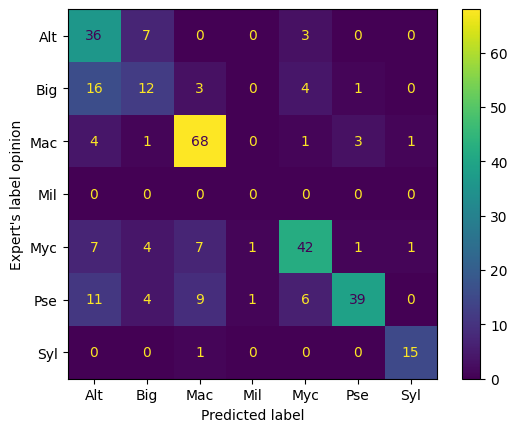

Accuracy : 0.686084142394822
Balanced Accuracy : 0.6915077374316505


/opt/mamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(may_true,
may_pred,labels=lb),display_labels=lb)
disp.plot()
plt.ylabel("Expert's label opinion")
plt.show()
print("Accuracy : "+str(accuracy_score(may_true, may_pred)))
print("Balanced Accuracy : "+str(balanced_accuracy_score(may_true, may_pred)))

### Per class homogeneity for Atypicals & Externals

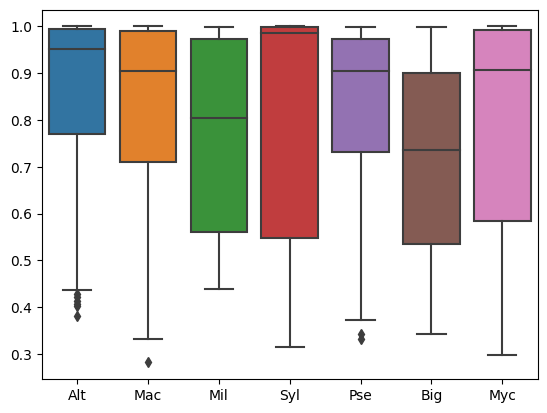

In [43]:
score=scoreAty
qui=y_predA_label
d = {'qui': qui, 'score': score}
df = pd.DataFrame(data=d)
ax = sns.boxplot(data=df,x=qui,y=score)
# plt.legend(labels=['Typ', 'Aty','Ext'])
plt.show()

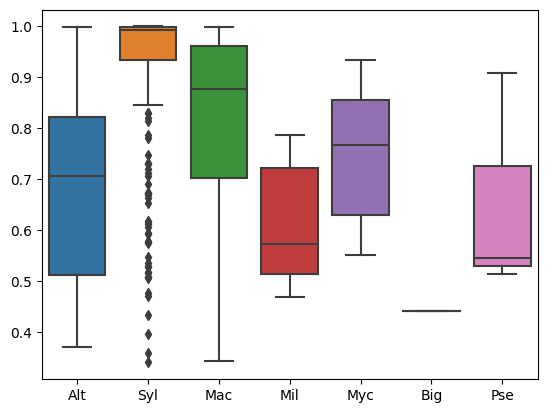

In [44]:
score=scoreExt
qui=y_predE_label
d = {'qui': qui, 'score': score}
df = pd.DataFrame(data=d)
ax = sns.boxplot(data=df,x=qui,y=score)
# plt.legend(labels=['Typ', 'Aty','Ext'])
plt.show()

### External Study

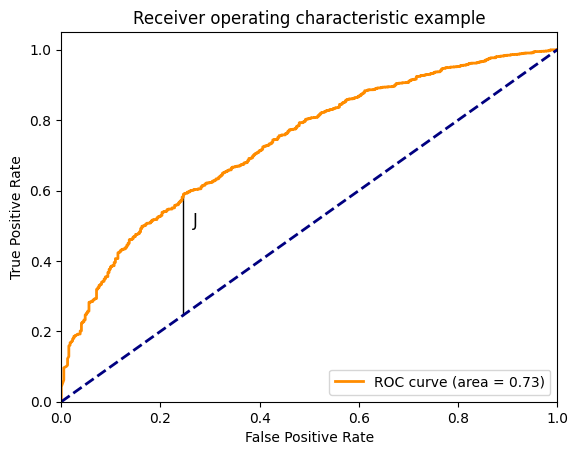

In [24]:
# courbe de ROC
from sklearn.metrics import roc_curve, auc
qui=np.concatenate((np.zeros(len(scoreTyp)),
                    np.zeros(len(scoreExt))+1))
score=np.concatenate((scoreTyp,scoreExt))
fpr, tpr, thresholds = roc_curve(qui,score,pos_label=0)
roc_auc = auc(fpr, tpr)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
plt.figure()
lw = 2
plt.plot([fpr[idx], fpr[idx]], [fpr[idx], tpr[idx]], color="black", lw=1, linestyle="-")
plt.plot(
fpr,
tpr,
color="darkorange",
lw=lw,
label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.annotate(text="J",xy=(fpr[idx]+0.02,0.5),fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [25]:
# computing younden's index (True Skill Statistic)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
print((thresholds[idx],tpr[idx],fpr[idx]))

import copy
out=copy.deepcopy(score)
out[score<seuil]=0
out[score>=seuil]=1

# precision
print((sum(out != qui) / out.shape)[0])

(0.9985747337341309, 0.5896013864818024, 0.24619289340101522)
0.6093321134492223


## On Externals that are not predicted symptomless

In [41]:
scoreExtDiffSyl = [score for (score,lab) in zip(scoreExt,y_predE_label) if lab!='Syl']

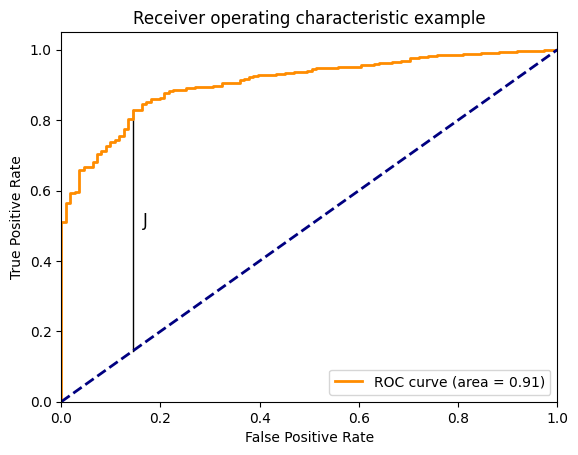

In [45]:
# courbe de ROC
from sklearn.metrics import roc_curve, auc
qui=np.concatenate((np.zeros(len(scoreTyp)),
                    np.zeros(len(scoreExtDiffSyl))+1))
score=np.concatenate((scoreTyp,scoreExtDiffSyl))
fpr, tpr, thresholds = roc_curve(qui,score,pos_label=0)
roc_auc = auc(fpr, tpr)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
plt.figure()
lw = 2
plt.plot([fpr[idx], fpr[idx]], [fpr[idx], tpr[idx]], color="black", lw=1, linestyle="-")
plt.plot(
fpr,
tpr,
color="darkorange",
lw=lw,
label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.annotate(text="J",xy=(fpr[idx]+0.02,0.5),fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [46]:
# computing younden's index (True Skill Statistic)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
print((thresholds[idx],tpr[idx],fpr[idx]))

import copy
out=copy.deepcopy(score)
out[score<seuil]=0
out[score>=seuil]=1

# precision
print((sum(out != qui) / out.shape)[0])

(0.9625144600868225, 0.8277296360485269, 0.14414414414414414)
0.8287716955941254


### Misclassified Study 

In [31]:
scoreMis = [score for (pred,real,score) in zip(all_outputs[model.name]['pred'],y_obs,all_outputs[model.name]['max_probs']) if pred!=real]
scoreCla = [score for (pred,real,score) in zip(all_outputs[model.name]['pred'],y_obs,all_outputs[model.name]['max_probs']) if pred==real]

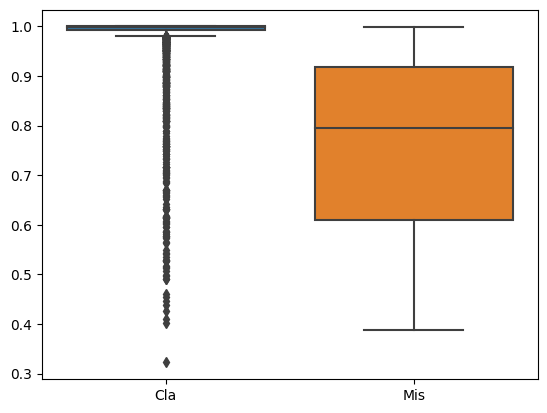

In [32]:
score=np.concatenate((scoreCla,scoreMis))
qui=np.concatenate((np.repeat("Cla",len(scoreCla)),
np.repeat("Mis",len(scoreMis))))
d = {'qui': qui, 'score': score}
df = pd.DataFrame(data=d)
ax = sns.boxplot(data=df,x=qui,y=score)
plt.show()

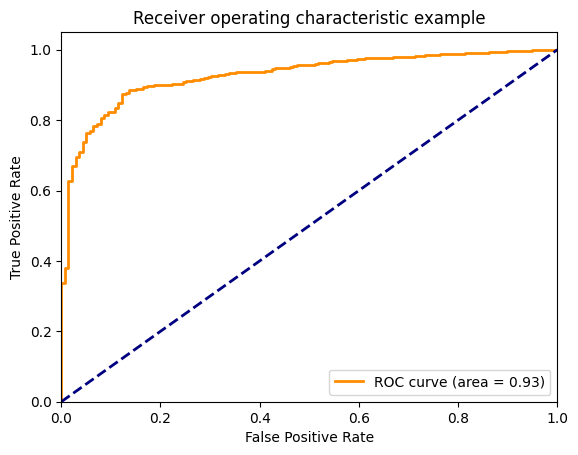

In [33]:
# courbe de ROC
from sklearn.metrics import roc_curve, auc
qui=np.concatenate((np.zeros(len(scoreCla)),
                    np.zeros(len(scoreMis))+1))
score=np.concatenate((scoreCla,scoreMis))
fpr, tpr, thresholds = roc_curve(qui,score,pos_label=0)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
fpr,
tpr,
color="darkorange",
lw=lw,
label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [34]:
# computing younden's index (True Skill Statistic)
idx = (tpr-fpr).argmax()
seuil = thresholds[idx]
print((thresholds[idx],tpr[idx],fpr[idx]))

import copy
out=copy.deepcopy(score)
out[score<seuil]=0
out[score>=seuil]=1

# precision
print((sum(out != qui) / out.shape)[0])

(0.9560564160346985, 0.8736343772760379, 0.1223021582733813)
0.8738301559792028
